# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

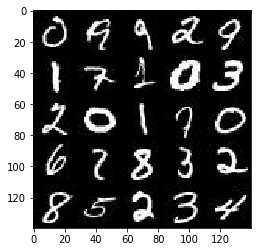

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

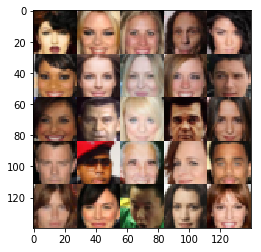

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding="SAME",
                              kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 7x7x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer =tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        #4x4x256 now
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2,):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function 
        
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 2x2x512 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 256, 3, strides=2, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 4x4x256 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 128, 4, strides=1, padding='VALID')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 7x7x128
        
        # Hidden Layer 4
        h4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        #print ('Layer 3:', h4.shape)
        # 14x14x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:',logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model   
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4664... Generator Loss: 2.3435
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 4.8500
Epoch 1/2... Discriminator Loss: 0.4203... Generator Loss: 5.2896
Epoch 1/2... Discriminator Loss: 2.3701... Generator Loss: 0.1635
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 5.9739
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.4694
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 4.3124
Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 4.2370


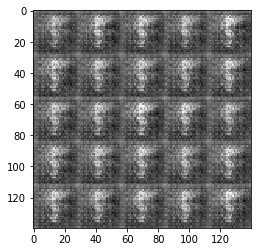

Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 2.7950
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 2.6428
Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 2.7856
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 2.5183
Epoch 1/2... Discriminator Loss: 0.3999... Generator Loss: 3.4702
Epoch 1/2... Discriminator Loss: 0.4019... Generator Loss: 3.5897
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 4.2437
Epoch 1/2... Discriminator Loss: 0.4247... Generator Loss: 3.7325
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 3.0711
Epoch 1/2... Discriminator Loss: 0.4332... Generator Loss: 3.0436


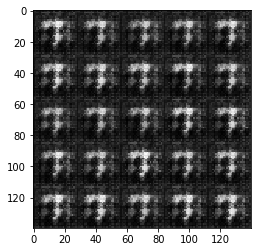

Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 4.1625
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 3.3778
Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 4.6742
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 2.7439
Epoch 1/2... Discriminator Loss: 0.4481... Generator Loss: 3.3673
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 2.9851
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 4.0055
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 2.6572
Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 3.1970
Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 4.6805


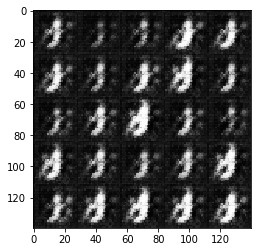

Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 2.7613
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 3.8698
Epoch 1/2... Discriminator Loss: 0.3898... Generator Loss: 3.7617
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 3.3191
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 4.2940
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 5.6153
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.9622
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 3.0844
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 2.2403
Epoch 1/2... Discriminator Loss: 0.5061... Generator Loss: 2.3037


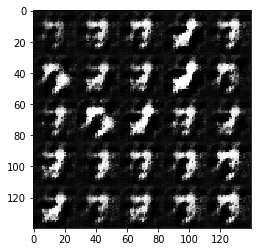

Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 2.2132
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 3.9966
Epoch 1/2... Discriminator Loss: 0.4783... Generator Loss: 3.9796
Epoch 1/2... Discriminator Loss: 0.4340... Generator Loss: 3.4734
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 3.8950
Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 2.5245
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 6.0757
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 3.3846
Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 3.3711
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 2.2808


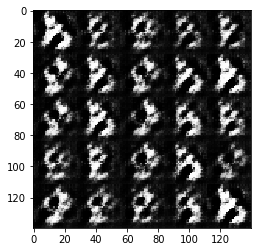

Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 3.2057
Epoch 1/2... Discriminator Loss: 0.4446... Generator Loss: 2.8451
Epoch 1/2... Discriminator Loss: 0.6652... Generator Loss: 3.0999
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 3.2714
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 2.6084
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 2.3246
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 4.5191
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 2.3775
Epoch 1/2... Discriminator Loss: 0.4866... Generator Loss: 2.7368


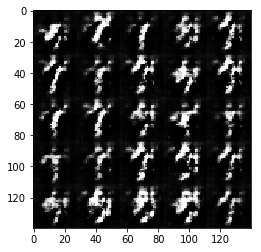

Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.3257
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 3.7697
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 3.8555
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 4.1070
Epoch 1/2... Discriminator Loss: 0.5438... Generator Loss: 2.6122
Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 2.1246
Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 2.6798
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 1.9473
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 2.6099
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 3.2090


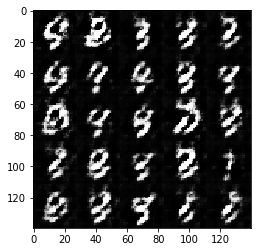

Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 3.6248
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 2.1981
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 5.2535
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.2611
Epoch 1/2... Discriminator Loss: 0.5338... Generator Loss: 2.6455
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 3.1650
Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 2.4427
Epoch 1/2... Discriminator Loss: 0.5762... Generator Loss: 2.2831
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 2.8355


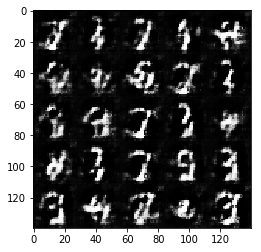

Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.2330
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 3.3718
Epoch 1/2... Discriminator Loss: 2.0236... Generator Loss: 6.8846
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 3.0978
Epoch 1/2... Discriminator Loss: 0.5941... Generator Loss: 2.6538
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.6079
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 2.5908
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.6095
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 3.5098
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 3.0097


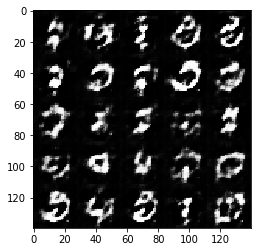

Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.5666
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 2.2619
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 3.0755
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 2.7701
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 2.2200
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 2.2229
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 2.2260
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.8148


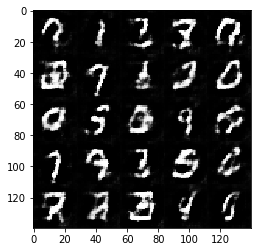

Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 2.4902
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 2.4393
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 2.1800
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.9186
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.9287
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 2.9550
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 2.0397
Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 3.4021


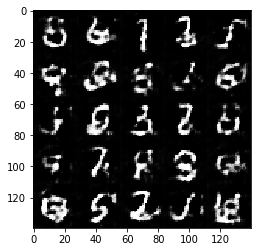

Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.6962
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 2.7362
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 1.9333
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.3939
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 1.4947
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.5145
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 2.9592
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.2973


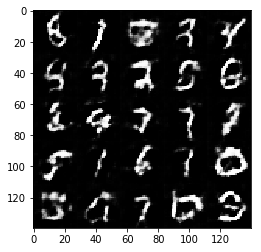

Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 2.7378
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.5232
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 2.0940
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.5829
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 3.1841
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.4337
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 2.4059
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.4422


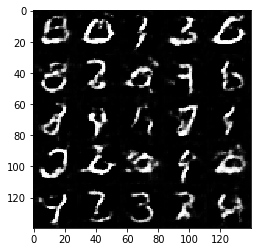

Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.2237
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 2.5323
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 2.8869
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.6605
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.9225
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 2.7059


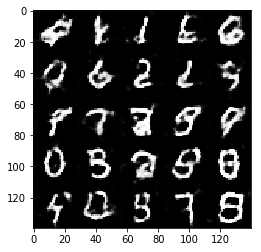

Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.5647
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.4955
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.2948
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.3735
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 2.7198
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.2327
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.4826
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.6811


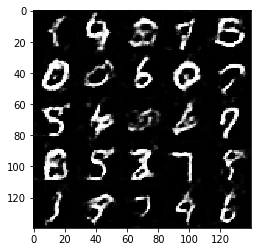

Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 1.5323
Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.5156
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.1264
Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 1.7416
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.0091
Epoch 2/2... Discriminator Loss: 1.7766... Generator Loss: 3.9144
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.5339


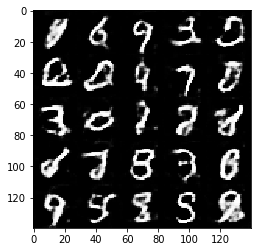

Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.5085
Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.4573
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.8343
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 2.2142
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 2.3099
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 2.3682
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 3.1608


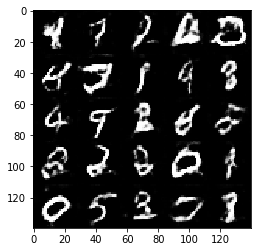

Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 2.1639
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 2.0292
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.5374
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.3773
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.9836
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.0723


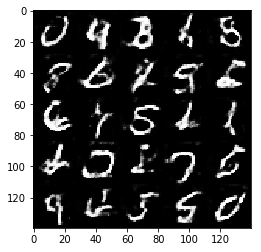

Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.1076
Epoch 2/2... Discriminator Loss: 1.9766... Generator Loss: 4.2082
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.7107
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.8758
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 1.6505


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.3818
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 5.7116
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.0488
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 6.8797
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 5.2714
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 5.2249
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 5.5122
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 4.2075


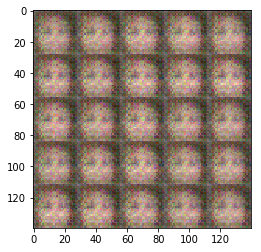

Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.2591
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 3.5569
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 5.8846
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 3.3345
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.7572


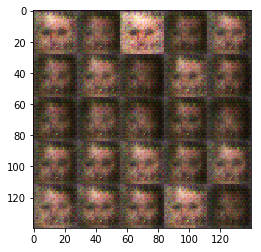

Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 4.0642
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 2.3887
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 3.0899
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.2157
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 2.6629
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 2.7066


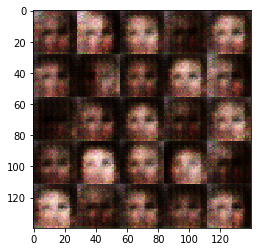

Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 3.6290
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 3.1295
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.8679


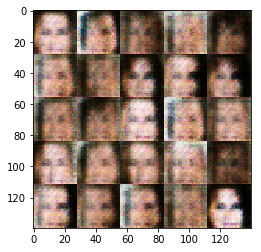

Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 2.4413
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.9017
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 4.8853
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.9782
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 5.0626
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0586


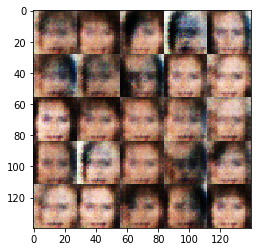

Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 3.4999
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.8546
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.8687


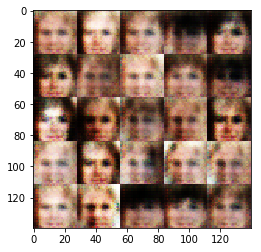

Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 3.4038
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 6.0221
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 2.5900
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.6107
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 2.9187
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 5.3460


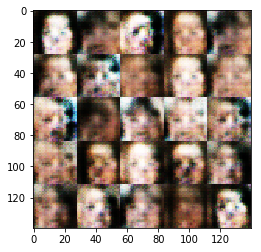

Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 2.7427
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 2.5901
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 2.3180
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 3.0356
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.5847


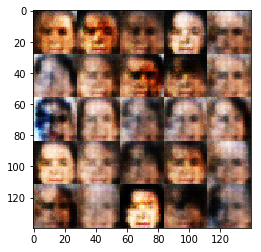

Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 3.2251
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 3.0294
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.6522
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.8982
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 4.0746
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 3.2158
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 1.9128


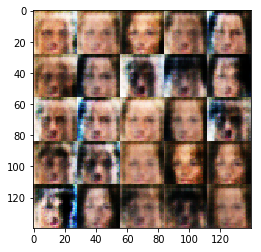

Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.6827
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 3.3140
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 2.2229
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 5.1753
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 2.1631
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 2.4090


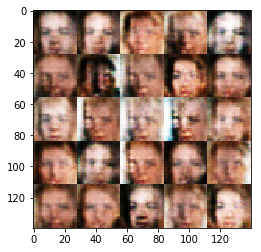

Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.5422
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 3.0493
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 2.7943
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.6204
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 2.5847
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.8070
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.4614


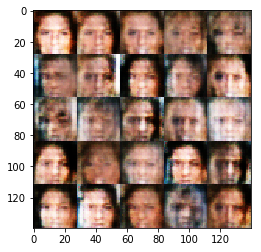

Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 4.0843
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.8518
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 2.2095
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.6307
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.5655


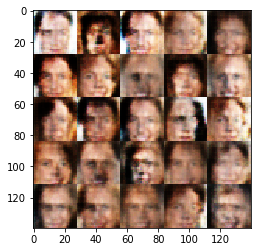

Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 2.9546
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 2.2659
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.9430


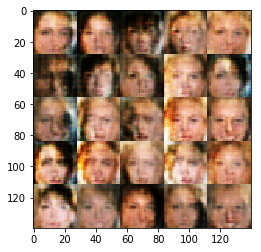

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 2.3164
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 2.0867
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 3.5922
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.6187


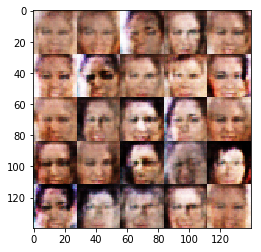

Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 2.1758
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.9749
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.4402
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 2.2802
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.5139


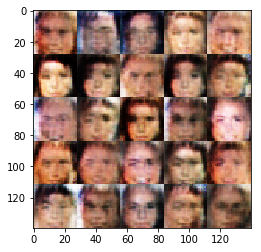

Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 2.1015
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 2.1480
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.5998
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 2.6599
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.8470


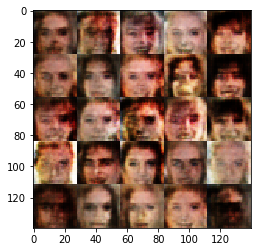

Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 2.0664
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.5936
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.3932
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.1738


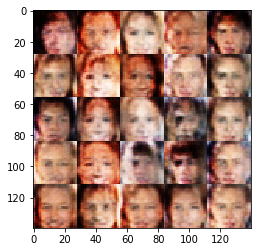

Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.8392
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 2.3191
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0131


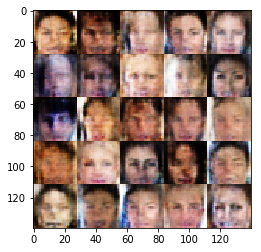

Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 2.9244
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 2.1175
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.7106
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 2.2145


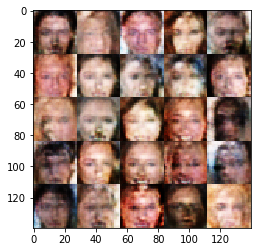

Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 2.4500
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.9385
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.7171
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.5006
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.3389


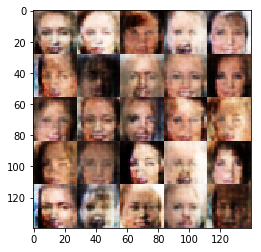

Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.7234
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.7693
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.4649
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.8366


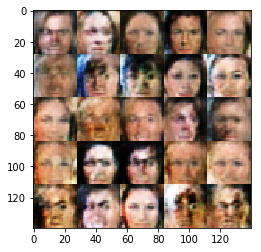

Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.7126
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 3.4386


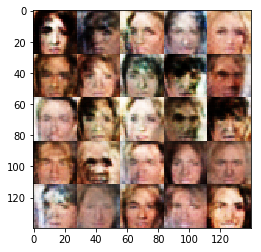

Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.2264
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.0605
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.6913


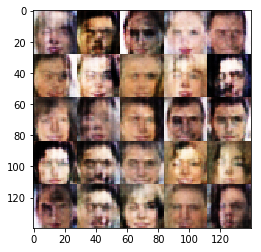

Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 2.1391
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.7493


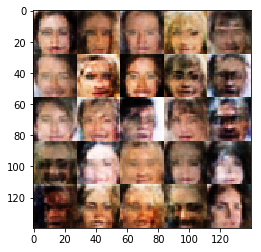

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.5443


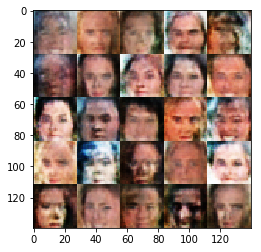

Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.8581
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 2.2452
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 2.2921
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.7547
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 2.0110
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.5413


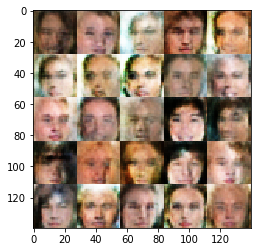

Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.8506
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.7939
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.3315
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.4970


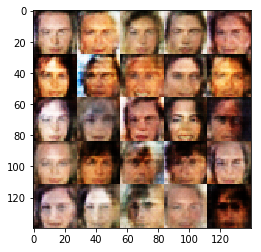

Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 2.2217
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 3.5846
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.9271
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 2.1529
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.1568


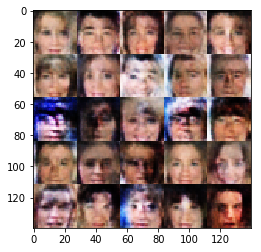

Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 3.8980
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.8590
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 2.0861
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.9463


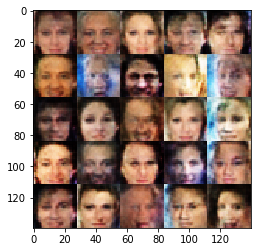

Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 2.1725
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.7258
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.9500


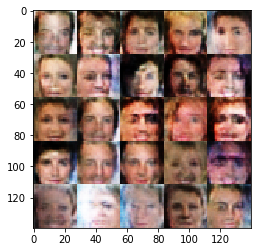

Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 2.2035


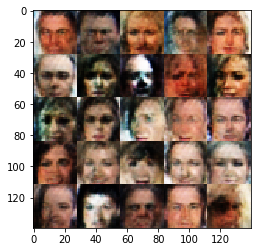

Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.2920
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 2.4296
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 2.2099


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.